In [892]:
from copy import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import scipy.stats as stats
from scipy.stats import multivariate_normal
from sklearn.compose import TransformedTargetRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [902]:
def bayesian_update(mu, sigma, x_matrix, y, sigma_noise=0.5):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), mu) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y))
    return mu_n, sigma_n

def plot_heatmap(Z):
    plt.axis('equal')
#     plt.xlim((-1, 1))
#     plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    
def plot(x, y_true, y_pred, title):
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=14)
    plt.plot(x[:, 1], y_true, label='True')
    plt.plot(x[:, 1], y_pred, label='Predicted')
    plt.legend(fontsize=legend_fontsize)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
def predict_by_params(param, data, cumsum):
    res = np.exp(np.matmul(data, param.reshape(-1, 1))[:,0])
    if cumsum:
        return np.cumsum(res)
    else:
        return res

def sample_statistics(mu, sigma, data, n, cumsum):
    params = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, data.shape[0]))
    for i, param in enumerate(params):
        res[i,:] = predict_by_params(param, data, cumsum=cumsum)
    return res

In [894]:
df = pd.read_csv("owid-covid-data.csv")
df = df[(df['location']=='Russia') & (df['date'] >= '2020-03-03')].reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])
df.loc[df['new_cases'] == 0, 'new_cases'] = 1

may_1 = df[df['date'] == '2020-05-01'].index[0]
june_1 = df[df['date'] == '2020-06-01'].index[0]
sep_1 = df[df['date'] == '2020-09-01'].index[0]

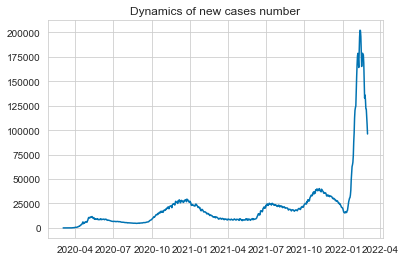

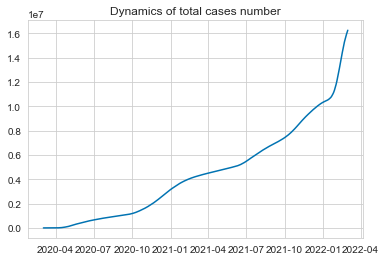

In [895]:
plt.figure()
plt.title("Dynamics of new cases number")
plt.plot(df['date'], df['new_cases'])

plt.figure()
plt.title("Dynamics of total cases number")
plt.plot(df['date'], df['total_cases'])

## Part 2

Parameters of linear model: [1.82073715 0.19829091]


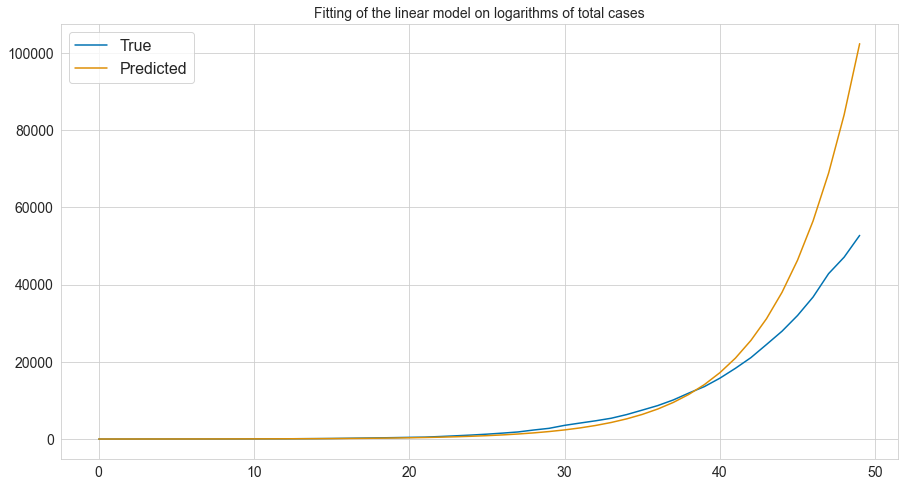

In [896]:
# Train linear model on logarithms of the target
num_days = 50 
degree = 1

poly = PolynomialFeatures(degree)
x_train = poly.fit_transform(np.arange(num_days).reshape(-1,1))
y_train = df['total_cases'].values[:num_days]

lin_model = TransformedTargetRegressor(regressor=LinearRegression(fit_intercept=False),
                                       func=np.log, 
                                       inverse_func=np.exp)

lin_model.fit(x_train, y_train)
print(f'Parameters of linear model: {lin_model.regressor_.coef_}')
y_pred_train = lin_model.predict(x_train)

plot(x_train, y_train, y_pred_train, title='Fitting of the linear model on logarithms of total cases')

C:\Users\Sergey\AppData\Local\Temp/ipykernel_15000/918864864.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


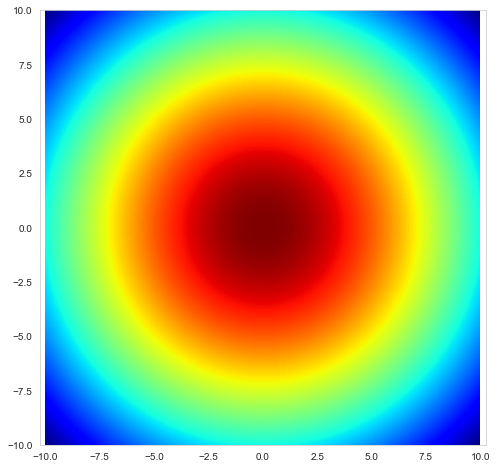

In [941]:
# As a priori consider bivariate normal distribution with zero mean and covariance matrix as follows
mu_cur, sigma_cur = np.array([0, 0]), 100 * np.eye(2)

num_points = 1000
X = np.linspace(-10, 10, num_points)
Y = np.linspace(-10, 10, num_points)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=mu_cur, cov=sigma_cur)

    
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax.set_xlim((xs[0], xs[-1]))
# ax.set_ylim((-2, 2))
plot_heatmap(Z)

In [942]:
mu_cur, sigma_cur = bayesian_update(mu_cur, sigma_cur, x_train, np.log(y_train), sigma_noise=0.15)
print(f'Updated mu: {mu_cur}')
print(f'Updated sigma: {sigma_cur}')
Z = multivariate_normal.pdf(pos, mean=mu_cur, cov=sigma_cur)

Updated mu: [1.82070544 0.19829187]
Updated sigma: [[ 1.74702827e-03 -5.29402504e-05]
 [-5.29402504e-05  2.16083627e-06]]


In [944]:
x_test = poly.fit_transform(np.arange(sep_1 + 1).reshape(-1,1))
y_test = df['total_cases'].values[:sep_1 + 1]
dates_test = df['date'].values[:sep_1 + 1]
sample = sample_statistics(mu_cur, sigma_cur, x_test, n=1000, cumsum=False)

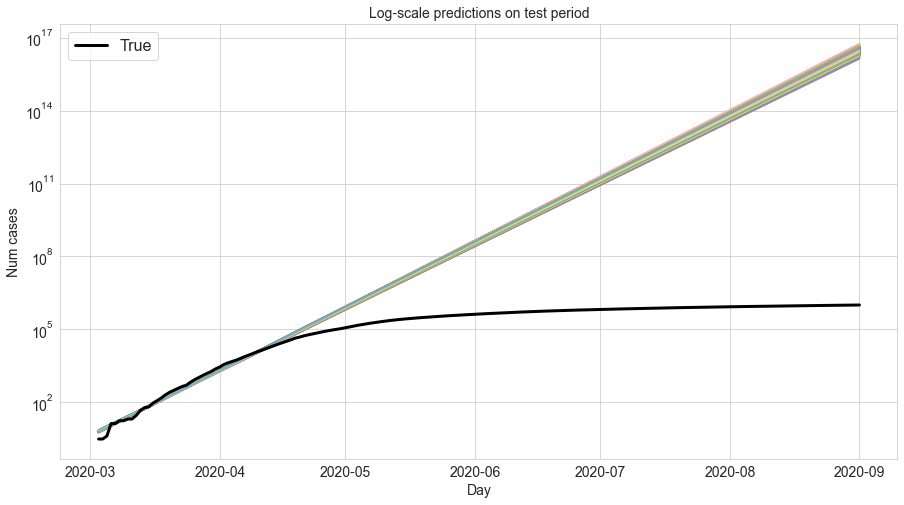

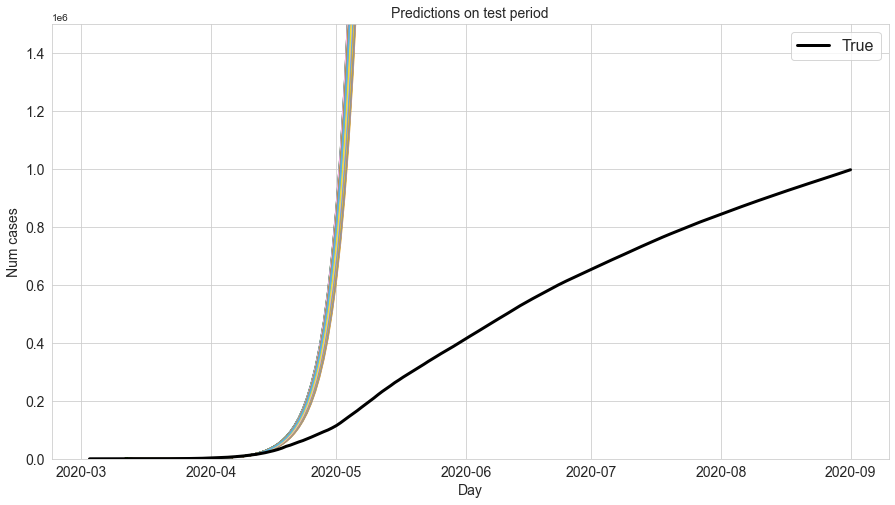

In [946]:
plt.figure(figsize=figsize)
plt.title("Log-scale predictions on test period", fontsize=14)
plt.plot(dates_test, sample.T)
plt.ylabel("Num cases", fontsize=14)
plt.xlabel("Day", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(dates_test, y_test, color='black', linewidth=3, label='True')
plt.legend(fontsize=legend_fontsize)
plt.yscale('log')
plt.show()

plt.figure(figsize=figsize)
plt.title("Predictions on test period", fontsize=14)
plt.plot(dates_test, sample.T)
plt.ylabel("Num cases", fontsize=14)
plt.xlabel("Day", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(dates_test, y_test, color='black', linewidth=3, label='True')
plt.legend(fontsize=legend_fontsize)
plt.ylim((0, 1.5e6))
plt.show()

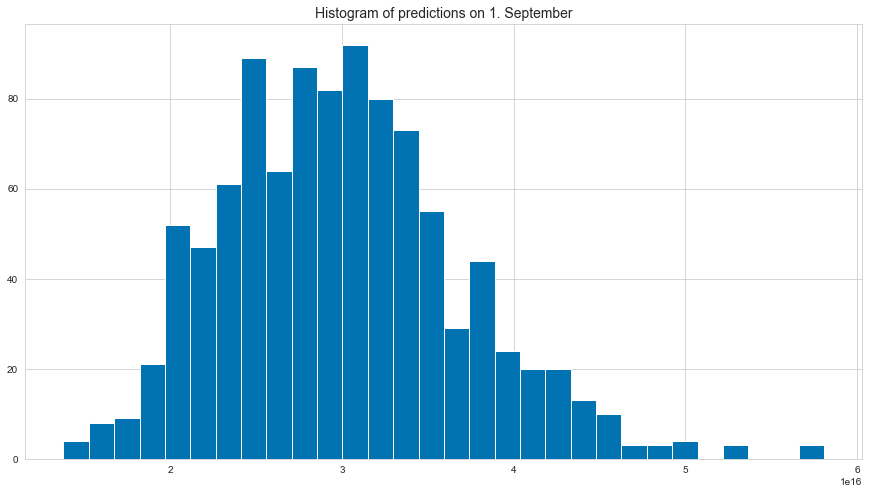

In [950]:
plt.figure(figsize=figsize)
plt.title("Histogram of predictions on 1. September", fontsize=14)
plt.hist(sample[:, sep_1], bins=30)
plt.show()

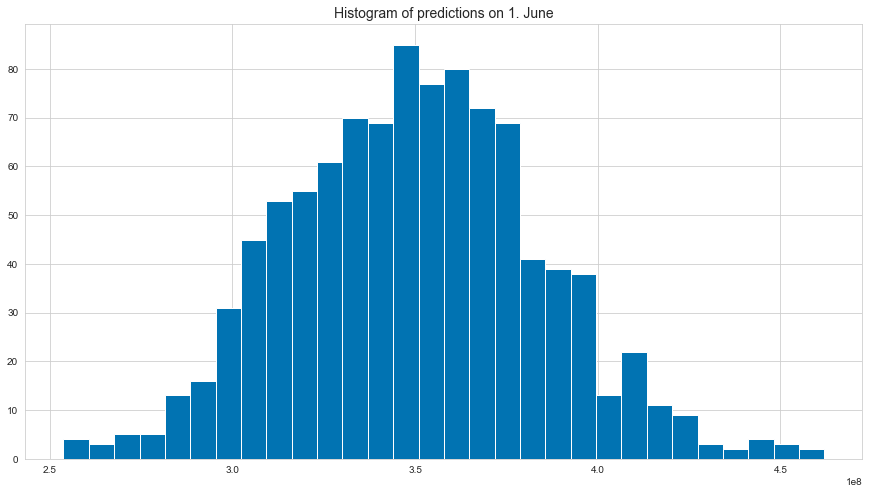

In [951]:
plt.figure(figsize=figsize)
plt.title("Histogram of predictions on 1. June", fontsize=14)
plt.hist(sample[:, june_1], bins=30)
plt.show()

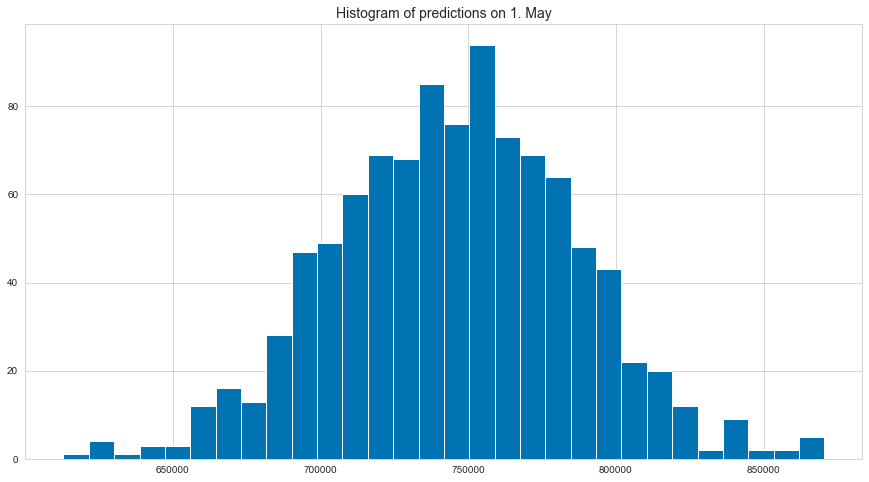

In [952]:
plt.figure(figsize=figsize)
plt.title("Histogram of predictions on 1. May", fontsize=14)
plt.hist(sample[:, may_1], bins=30)
plt.show()

## Part 3

Let's get a derivative w.r.t. x of F(x). 

On one hand, it equals to exp(ax^2+bx+c), on the other hand it equals to daily new cases. 

It means log(daily new cases) = ax^2+bx+c.

Therefore, we generate quadratic feature from x and fit linear model with log(daily new cases) as a target variable.

Parameters of linear model: [-0.3965904   0.27562283 -0.00182979]


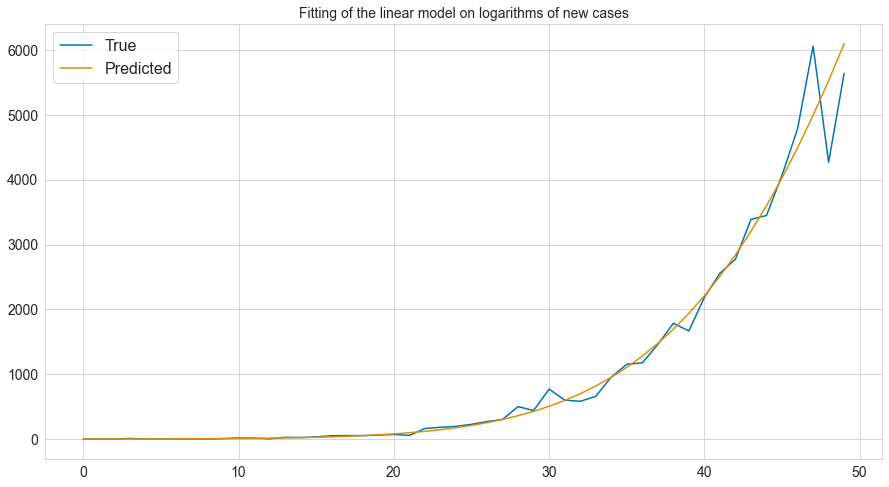

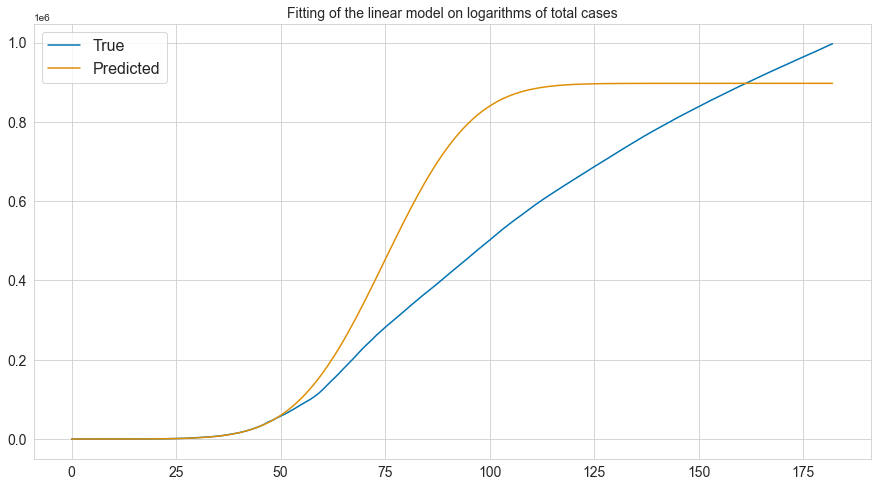

In [953]:
num_days = 50 
degree = 2

poly = PolynomialFeatures(degree)
x_train = poly.fit_transform(np.arange(num_days).reshape(-1,1))
y_train = df['new_cases'].values[:num_days]

lin_model = TransformedTargetRegressor(regressor=LinearRegression(fit_intercept=False),
                                       func=np.log, 
                                       inverse_func=np.exp)

lin_model.fit(x_train, y_train)
print(f'Parameters of linear model: {lin_model.regressor_.coef_}')
y_pred_train = lin_model.predict(x_train)

plot(x_train,
     y_train,
     y_pred_train,
     title='Fitting of the linear model on logarithms of new cases')

x_test =  poly.fit_transform(np.arange(sep_1 + 1).reshape(-1,1))
y_pred_test = np.cumsum(lin_model.predict(x_test))

plot(x_test, 
     df['total_cases'].values[:sep_1 + 1],
     y_pred_test, 
     title='Fitting of the linear model on logarithms of total cases')

### Bayesian update

In [964]:
mu_cur, sigma_cur = np.array([0, 0, 0]), 10 * np.eye(3)
mu_cur, sigma_cur = bayesian_update(mu_cur, sigma_cur, x_train, np.log(y_train), sigma_noise=0.15)


x_test = poly.fit_transform(np.arange(sep_1 + 1).reshape(-1,1))
y_test = df['total_cases'].values[:sep_1 + 1]
dates_test = df['date'].values[:sep_1 + 1]
sample = sample_statistics(mu_cur, sigma_cur, x_test, n=1000, cumsum=True)

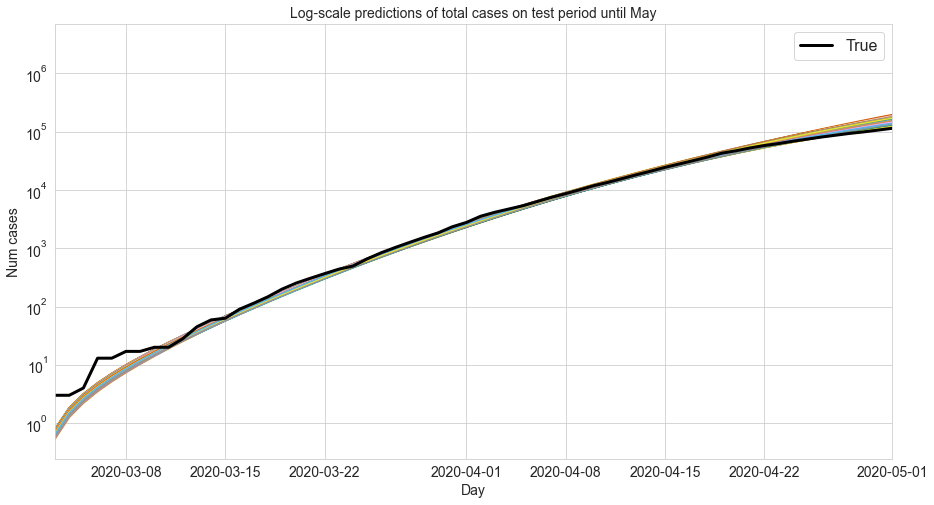

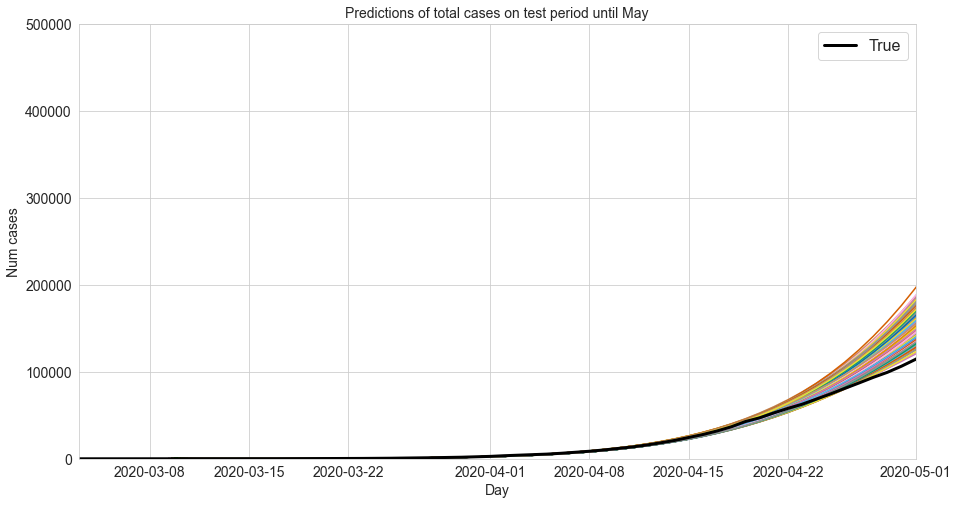

In [965]:
plt.figure(figsize=figsize)
plt.title("Log-scale predictions of total cases on test period until May", fontsize=14)
plt.plot(dates_test, sample.T)
plt.ylabel("Num cases", fontsize=14)
plt.xlabel("Day", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(dates_test, y_test, color='black', linewidth=3, label='True')
plt.legend(fontsize=legend_fontsize)
plt.yscale('log')
plt.xlim((dates_test[0], dates_test[may_1]))
plt.show()

plt.figure(figsize=figsize)
plt.title("Predictions of total cases on test period until May", fontsize=14)
plt.plot(dates_test, sample.T)
plt.ylabel("Num cases", fontsize=14)
plt.xlabel("Day", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(dates_test, y_test, color='black', linewidth=3, label='True')
plt.legend(fontsize=legend_fontsize)
plt.ylim((0, 0.5e6))
plt.xlim((dates_test[0], dates_test[may_1]))
plt.show()

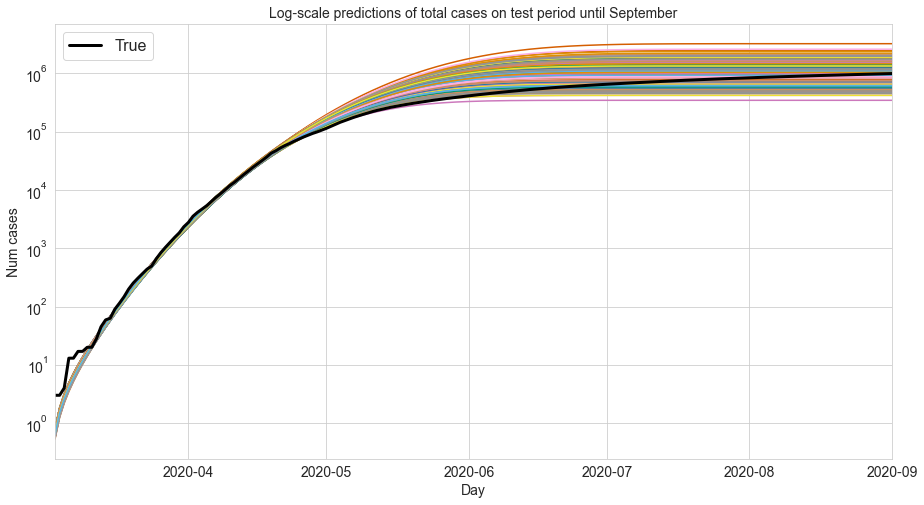

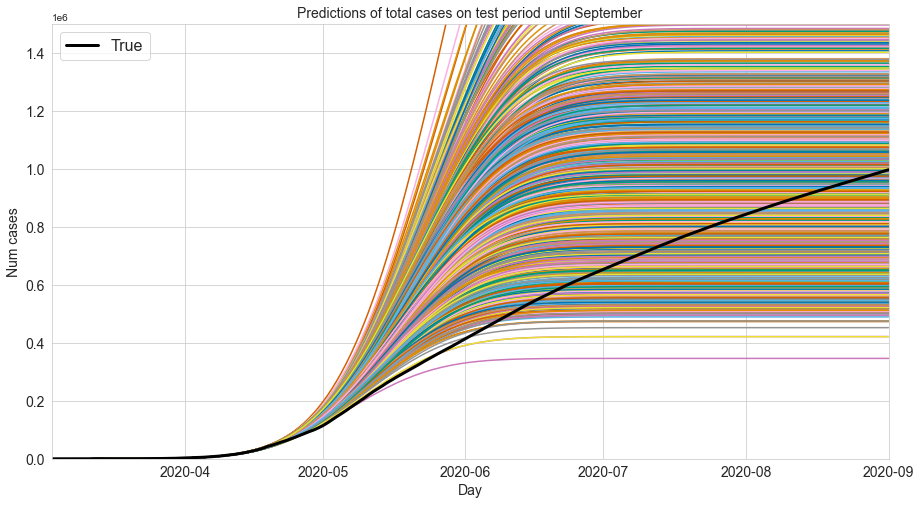

In [966]:
plt.figure(figsize=figsize)
plt.title("Log-scale predictions of total cases on test period until September", fontsize=14)
plt.plot(dates_test, sample.T)
plt.ylabel("Num cases", fontsize=14)
plt.xlabel("Day", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(dates_test, y_test, color='black', linewidth=3, label='True')
plt.legend(fontsize=legend_fontsize)
plt.yscale('log')
plt.xlim((dates_test[0], dates_test[sep_1]))
plt.show()

plt.figure(figsize=figsize)
plt.title("Predictions of total cases on test period until September", fontsize=14)
plt.plot(dates_test, sample.T)
plt.ylabel("Num cases", fontsize=14)
plt.xlabel("Day", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(dates_test, y_test, color='black', linewidth=3, label='True')
plt.legend(fontsize=legend_fontsize)
plt.ylim((0, 1.5e6))
plt.xlim((dates_test[0], dates_test[sep_1]))
plt.show()

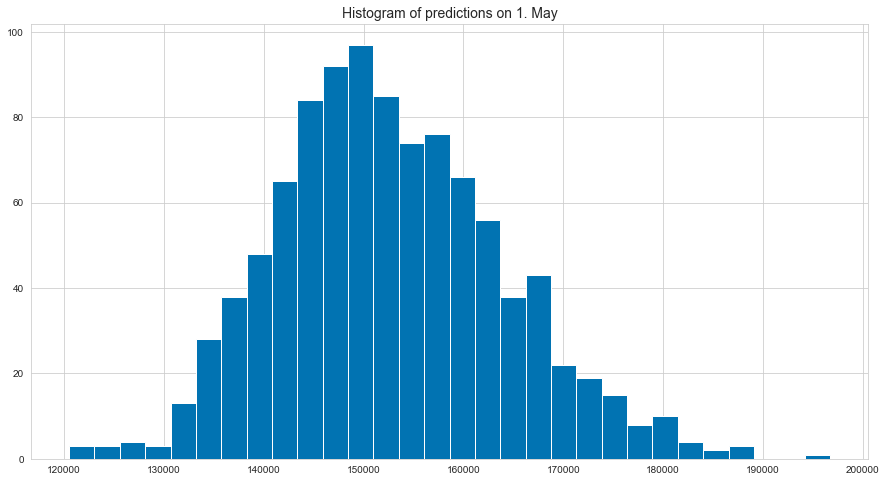

Optimistic number of cases by 1. May 2020: 138659.0
Pessimistic number of cases by 1. May 2020: 167526.0
True number of cases by 1. May 2020: 114431.0


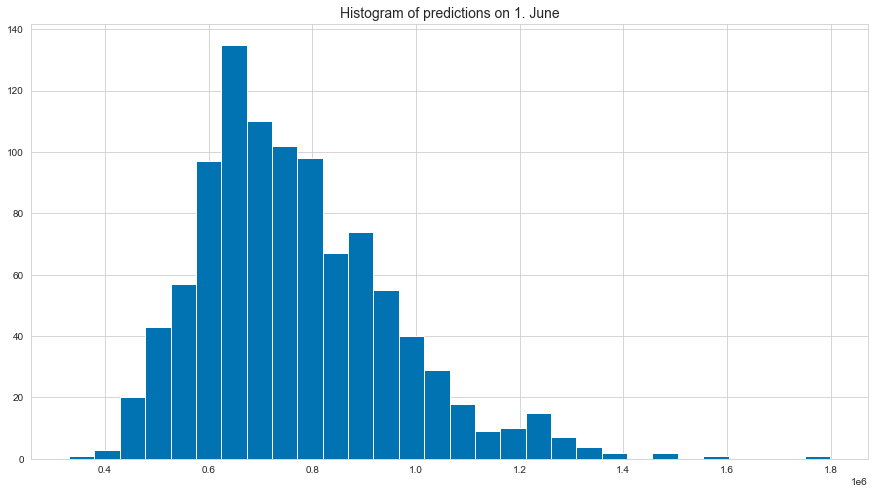

Optimistic number of cases by 1. June 2020: 559119.0
Pessimistic number of cases by 1. June 2020: 1014226.0
True number of cases by 1. June 2020: 414328.0


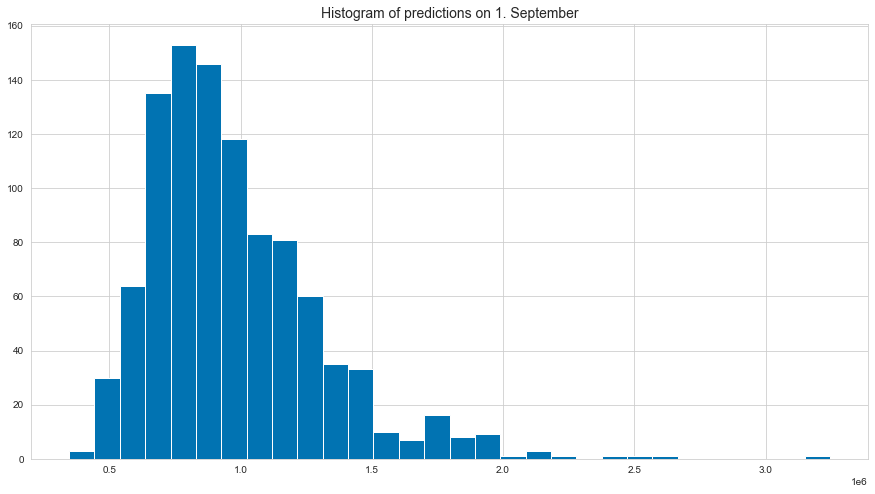

Optimistic number of cases by 1. September 2020: 640739.0
Pessimistic number of cases by 1. September 2020: 1370553.0
True number of cases by 1. September 2020: 997072.0


In [968]:
moments = [may_1, june_1, sep_1]
month = ['May', 'June', 'September']

for i, moment in enumerate(moments):
    plt.figure(figsize=figsize)
    plt.title(f"Histogram of predictions on 1. {month[i]}", fontsize=14)
    plt.hist(sample[:, moment], bins=30)
    plt.show()
    print(f'Optimistic number of cases by 1. {month[i]} 2020: {np.round(np.quantile(sample[:, moment], q=0.1))}')
    print(f'Pessimistic number of cases by 1. {month[i]} 2020: {np.round(np.quantile(sample[:, moment], q=0.9))}')
    print(f'True number of cases by 1. {month[i]} 2020: {y_test[moment]}')